In [196]:
from pathlib import Path
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

0. Getting the data

In [2]:
obesity_project_name = "playground-series-s4e2"

In [3]:
def load_obesity_data(project_name):
    zip_path = Path(f"{project_name}.zip")
    if not zip_path.is_file():
        !kaggle competitions download -c $project_name
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall()
    train_set = pd.read_csv(Path("train.csv"))
    test_set = pd.read_csv(Path("test.csv"))
    sample_submission = pd.read_csv(Path("sample_submission.csv"))
    return (train_set, test_set, sample_submission)

In [4]:
train_set, test_set, sample_submission = load_obesity_data(obesity_project_name)

In [5]:
train_set.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [7]:
for i in range(len(train_set.dtypes)):
    if train_set.dtypes.iloc[i] == "object":
        display(train_set.iloc[:, i].value_counts())

Gender
Female    10422
Male      10336
Name: count, dtype: int64

family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64

FAVC
yes    18982
no      1776
Name: count, dtype: int64

CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64

SMOKE
no     20513
yes      245
Name: count, dtype: int64

SCC
no     20071
yes      687
Name: count, dtype: int64

CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64

MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

In [8]:
train_set.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


1. Data exploration and visualization

In [9]:
train_set_exp = train_set.copy()

train_set_exp = train_set_exp.drop("id", axis=1)


# CAEC_to_number = {"Sometimes": 1, "Frequently": 2, "Always": 3, "no": 0}
# train_set_exp["CAEC_num"] = train_set_exp["CAEC"].map(CAEC_to_number)
# train_set_exp = train_set_exp.drop(columns=["CAEC"])

# CALC_to_number = {"Sometimes": 1, "Frequently": 2, "no": 0}
# train_set_exp["CALC_num"] = train_set_exp["CALC"].map(CALC_to_number)
# train_set_exp = train_set_exp.drop(columns=["CALC"])

# MTRANS_to_number = {"Public_Transportation": 1, "Automobile": 0, "Walking": 3, "Motorbike": 0, "Bike": 2}
# train_set_exp["MTRANS_num"] = train_set_exp["MTRANS"].map(MTRANS_to_number)
# train_set_exp = train_set_exp.drop(columns=["MTRANS"])

# NObeyesdad_to_number = {"Obesity_Type_III": 6, "Obesity_Type_II": 5, "Normal_Weight": 1, "Obesity_Type_I": 4, \
#                         "Insufficient_Weight": 0, "Overweight_Level_II": 3, "Overweight_Level_I": 2}
# train_set_exp["NObeyesdad_num"] = train_set_exp["NObeyesdad"].map(NObeyesdad_to_number)
# train_set_exp = train_set_exp.drop(columns=["NObeyesdad"])

cat_orders = {"CAEC" : ["no", "Sometimes", "Frequently", "Always"], 
              "CALC": ["no", "Sometimes", "Frequently"], 
              "MTRANS": ["Automobile", "Motorbike", "Public_Transportation", "Bike", "Walking"], 
              "NObeyesdad": ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II",
                             "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]}

ordinal_encoders = {}
for column in cat_orders:
    ordinal_encoders[column] = OrdinalEncoder(categories=[cat_orders[column]])
    encoded_values = ordinal_encoders[column].fit_transform(train_set_exp[[column]])
    train_set_exp[column + "_ordinal"] = encoded_values
    train_set_exp = train_set_exp.drop(column, axis=1)

display(train_set_exp)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,CAEC_ordinal,CALC_ordinal,MTRANS_ordinal,NObeyesdad_ordinal
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,no,2.763573,no,0.000000,0.976473,1.0,1.0,2.0,3.0
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,no,2.000000,no,1.000000,1.000000,2.0,0.0,0.0,1.0
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,no,1.910378,no,0.866045,1.673584,1.0,0.0,2.0,0.0
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,no,1.674061,no,1.467863,0.780199,1.0,1.0,2.0,6.0
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,no,1.979848,no,1.967973,0.931721,1.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,no,2.151809,no,1.330519,0.196680,1.0,1.0,2.0,5.0
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,no,1.000000,no,2.000000,1.000000,2.0,1.0,2.0,0.0
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,no,2.000000,no,1.158040,1.198439,1.0,0.0,2.0,5.0
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,no,2.144838,no,0.000000,0.973834,1.0,0.0,0.0,3.0


In [10]:
train_set_exp_binary = train_set_exp[["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]]
ordinal_encoder_binary = OrdinalEncoder()
ordinal_encoder_binary.fit(train_set_exp_binary)
train_set_exp_binary = pd.DataFrame(ordinal_encoder_binary.transform(train_set_exp_binary),
                                    columns=ordinal_encoder_binary.get_feature_names_out(), index=train_set_exp_binary.index)

train_set_exp_tmp = train_set_exp.drop(train_set_exp_binary.columns, axis=1)
train_set_exp = pd.concat([train_set_exp_tmp, train_set_exp_binary], axis=1)
display(train_set_exp)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CAEC_ordinal,CALC_ordinal,MTRANS_ordinal,NObeyesdad_ordinal,Gender,family_history_with_overweight,FAVC,SMOKE,SCC
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,1.0,1.0,2.0,6.0,0.0,1.0,1.0,0.0,0.0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,1.0,1.0,2.0,5.0,1.0,1.0,1.0,0.0,0.0
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,2.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,1.0,0.0,2.0,5.0,1.0,1.0,1.0,0.0,0.0
20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0


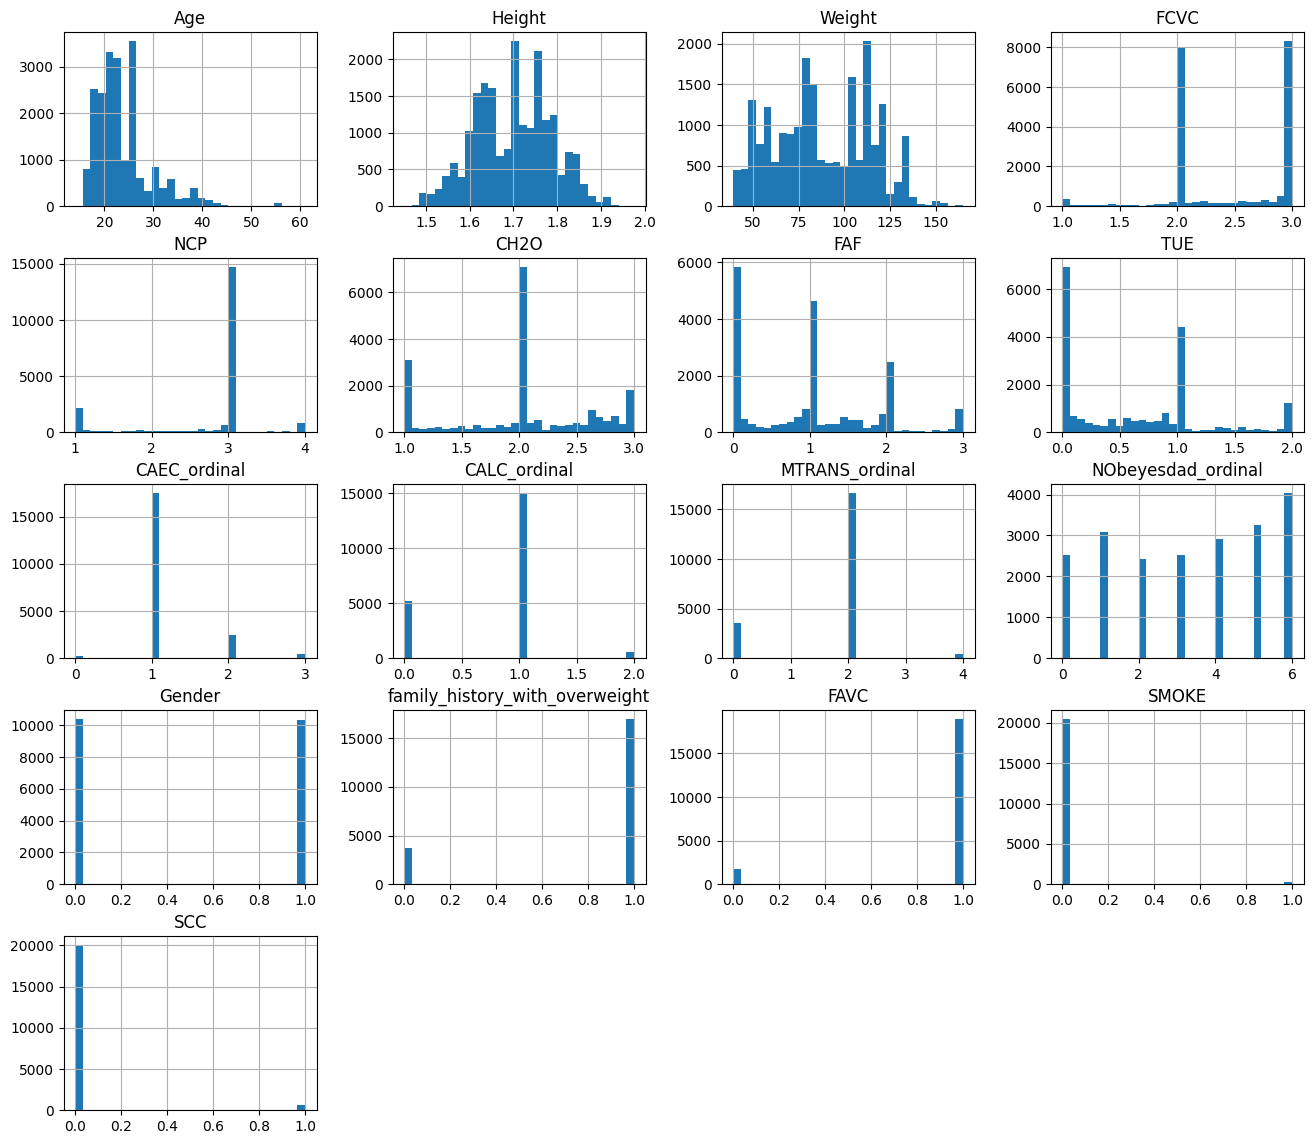

In [11]:
train_set_exp.hist(bins=30, figsize=(16, 14))
plt.show()

In [12]:
num_attributes = []
for column in train_set_exp.columns:
    if train_set_exp.dtypes[column] != "object":
        num_attributes.append(column)

corr_matrix = train_set_exp[num_attributes].corr()
display(corr_matrix)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CAEC_ordinal,CALC_ordinal,MTRANS_ordinal,NObeyesdad_ordinal,Gender,family_history_with_overweight,FAVC,SMOKE,SCC
Age,1.000000,-0.011713,0.283381,0.034414,-0.048479,-0.016325,-0.192259,-0.296154,-0.151498,0.070323,-0.577644,0.356211,0.066530,0.261575,0.056848,0.056006,-0.108855
Height,-0.011713,1.000000,0.416677,-0.071546,0.191383,0.183706,0.295278,0.076433,-0.069003,0.089138,-0.034638,0.150141,0.623507,0.228137,0.115566,0.069748,-0.095923
Weight,0.283381,0.416677,1.000000,0.245682,0.095947,0.317914,-0.084845,-0.086471,-0.337331,0.216673,-0.033487,0.921250,0.118613,0.514147,0.228770,0.040416,-0.185116
FCVC,0.034414,-0.071546,0.245682,1.000000,0.113349,0.101299,-0.089822,-0.147843,0.010870,0.128793,0.083540,0.272933,-0.312766,0.047756,0.006952,-0.012191,0.022120
NCP,-0.048479,0.191383,0.095947,0.113349,1.000000,0.080949,0.100871,0.067459,0.089957,0.099421,0.009428,0.027227,0.039468,0.044778,0.011522,0.006820,0.006633
CH2O,-0.016325,0.183706,0.317914,0.101299,0.080949,1.000000,0.082932,-0.010654,-0.132820,0.082735,0.071137,0.273154,0.053298,0.191588,0.039167,-0.023475,-0.031720
FAF,-0.192259,0.295278,-0.084845,-0.089822,0.100871,0.082932,1.000000,0.021213,0.092035,-0.090076,0.048916,-0.234745,0.238399,-0.094414,-0.067030,0.008374,0.061828
TUE,-0.296154,0.076433,-0.086471,-0.147843,0.067459,-0.010654,0.021213,1.000000,0.049646,-0.079790,0.181494,-0.121009,0.058696,0.005762,0.034843,-0.016093,-0.007917
CAEC_ordinal,-0.151498,-0.069003,-0.337331,0.010870,0.089957,-0.132820,0.092035,0.049646,1.000000,-0.066821,0.065172,-0.364052,-0.046129,-0.204263,-0.115675,0.019703,0.099427
CALC_ordinal,0.070323,0.089138,0.216673,0.128793,0.099421,0.082735,-0.090076,-0.079790,-0.066821,1.000000,-0.007816,0.189361,-0.037345,-0.002330,0.080184,0.023254,0.000208


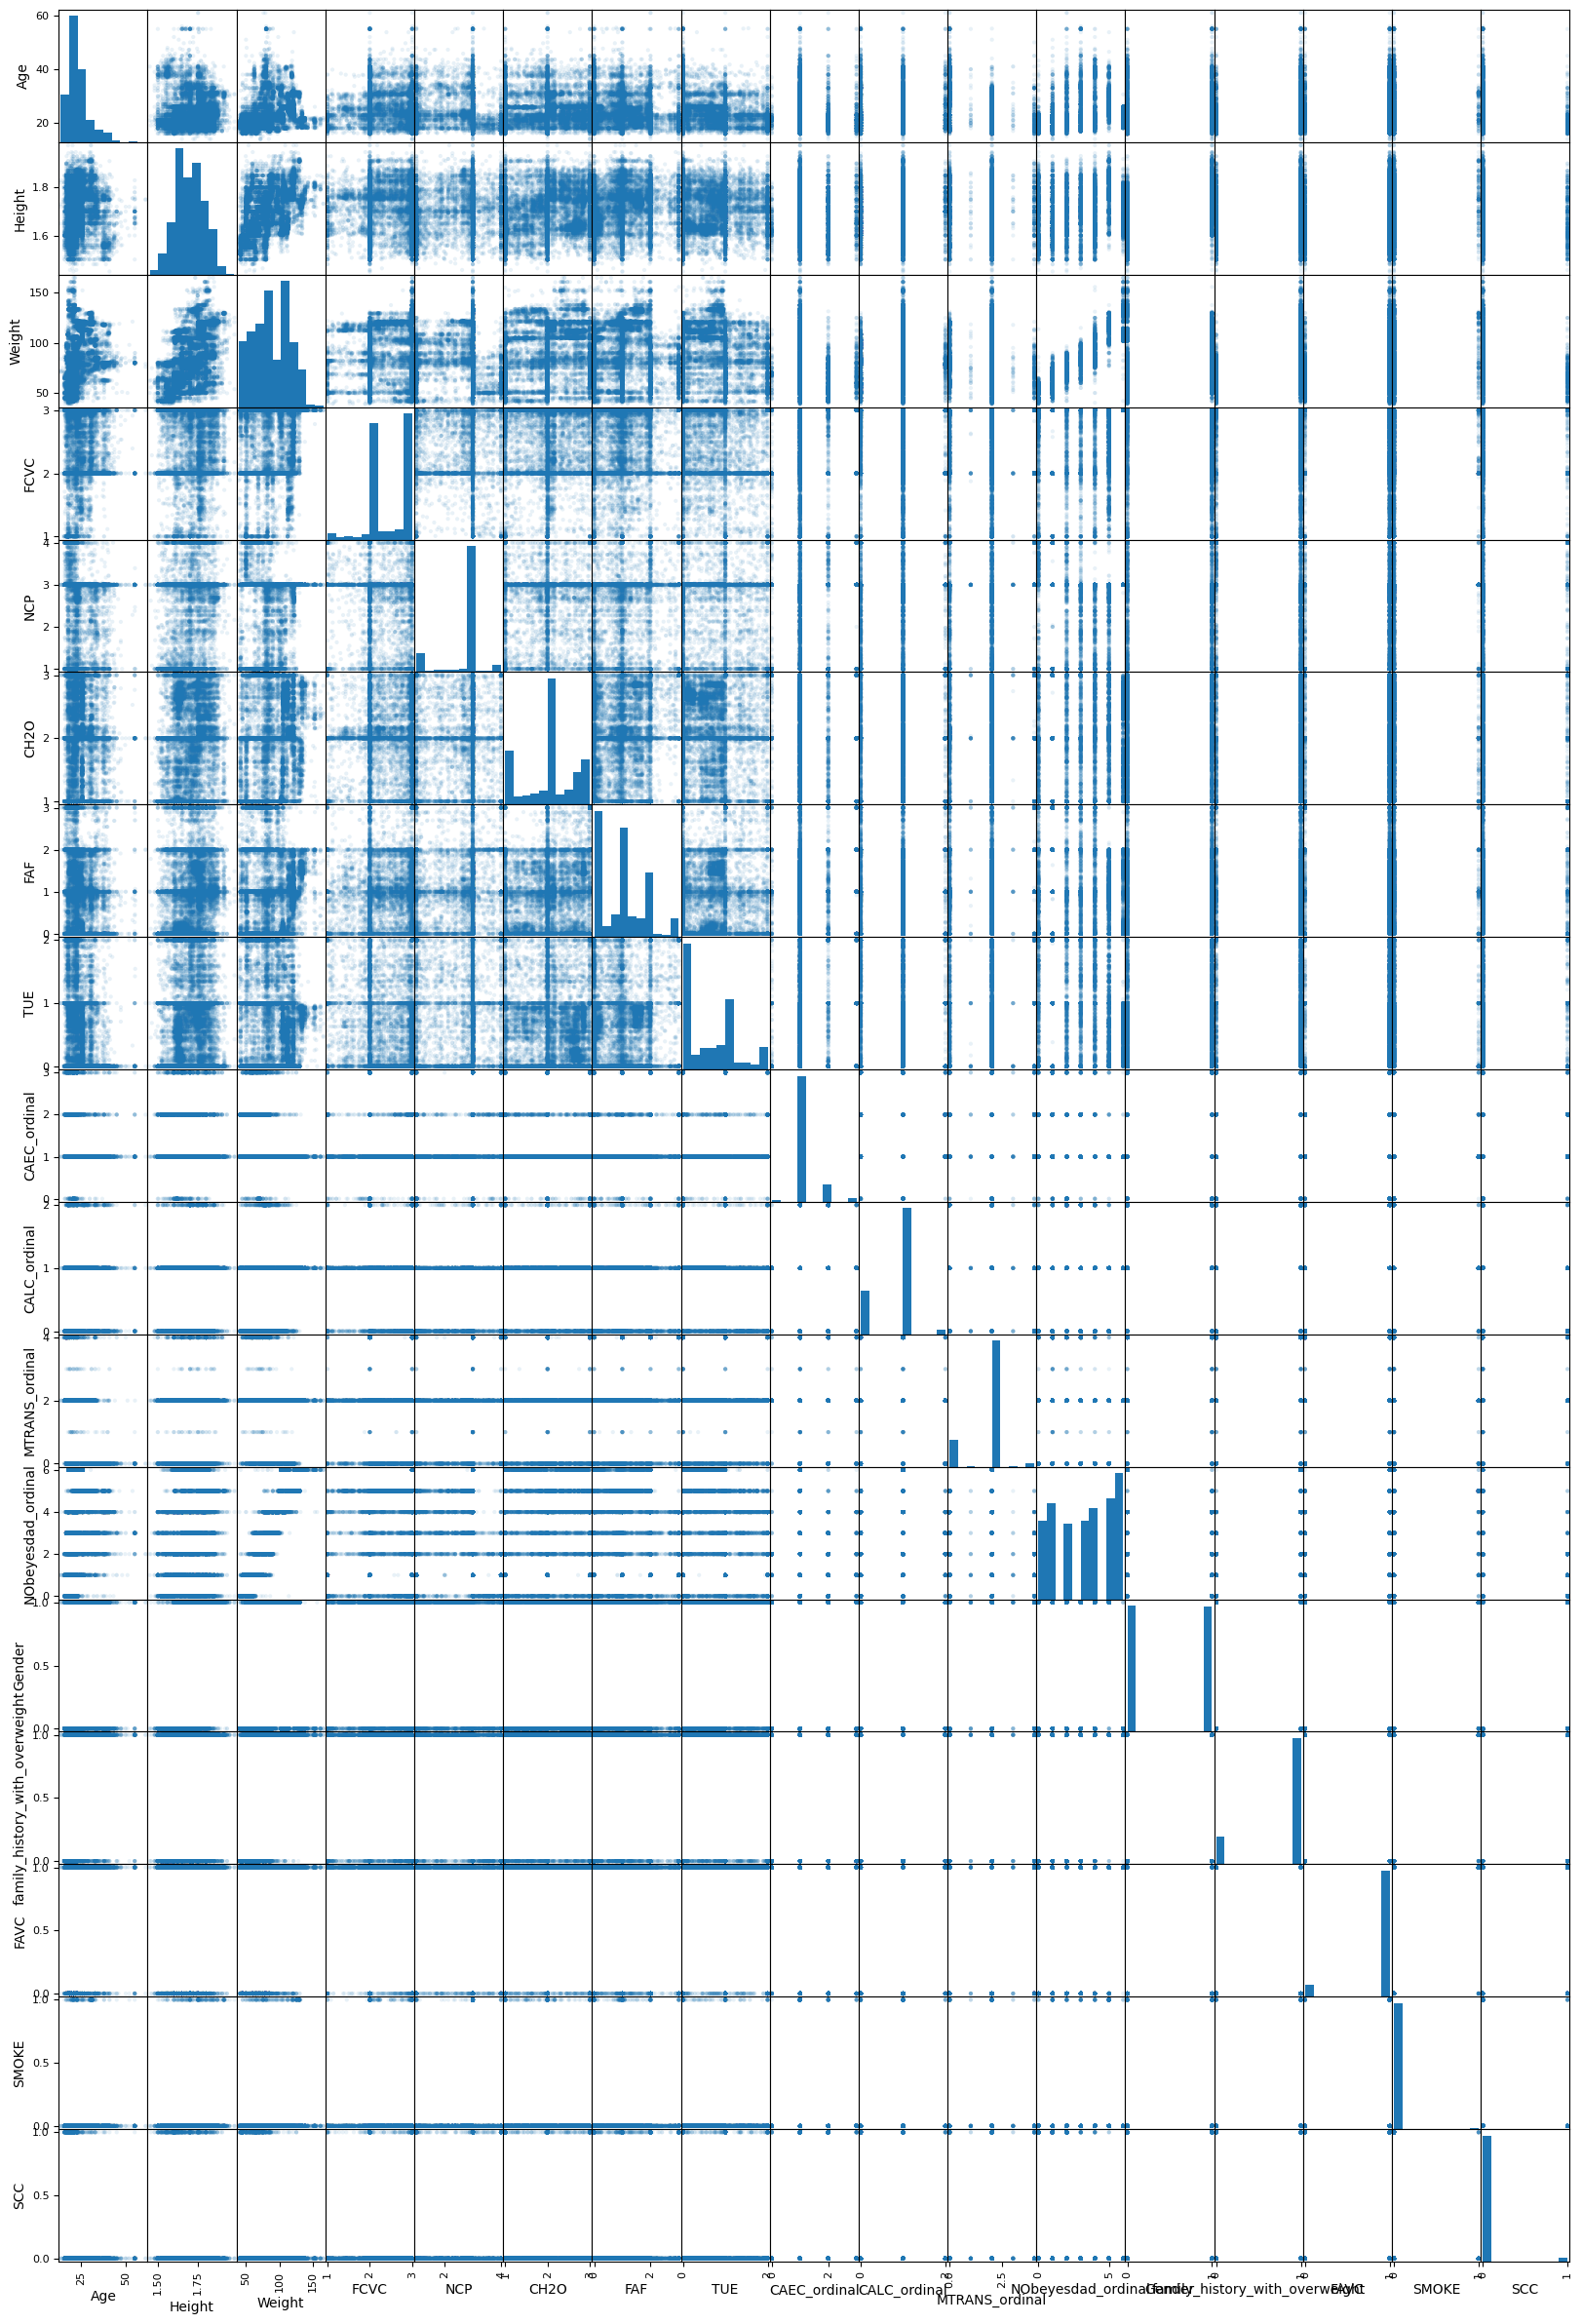

In [13]:
scatter_matrix(train_set_exp, alpha=0.1, figsize=(20, 30))
plt.show()

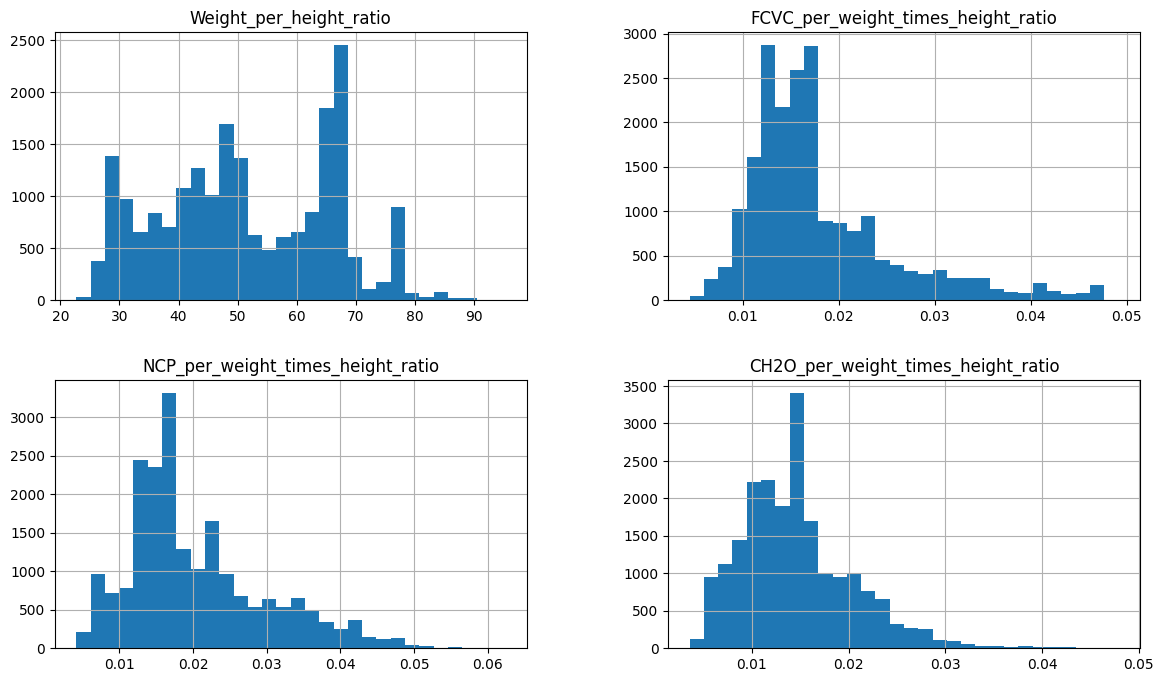

In [14]:
new_attributes = ["Weight_per_height_ratio", "FCVC_per_weight_times_height_ratio", "NCP_per_weight_times_height_ratio", "CH2O_per_weight_times_height_ratio"]

train_set_exp[new_attributes[0]] = train_set_exp["Weight"] / train_set_exp["Height"]
train_set_exp[new_attributes[1]] = train_set_exp["FCVC"] / (train_set_exp["Weight"] * train_set_exp["Height"])
train_set_exp[new_attributes[2]] = train_set_exp["NCP"] / (train_set_exp["Weight"] * train_set_exp["Height"])
train_set_exp[new_attributes[3]] = train_set_exp["CH2O"] / (train_set_exp["Weight"] * train_set_exp["Height"])

train_set_exp[[new_attributes[0], new_attributes[1], new_attributes[2], new_attributes[3]]].hist(bins=30, figsize=(14, 8))
plt.show()

In [15]:
display(train_set_exp)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CAEC_ordinal,CALC_ordinal,...,NObeyesdad_ordinal,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,Weight_per_height_ratio,FCVC_per_weight_times_height_ratio,NCP_per_weight_times_height_ratio,CH2O_per_weight_times_height_ratio
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1.0,1.0,...,3.0,1.0,1.0,1.0,0.0,0.0,48.041204,0.014405,0.021487,0.019905
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,2.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,36.538462,0.022492,0.033738,0.022492
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,29.311672,0.021903,0.016442,0.022251
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,1.0,1.0,...,6.0,0.0,1.0,1.0,0.0,0.0,76.736160,0.013359,0.013359,0.007454
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1.0,1.0,...,3.0,1.0,1.0,1.0,0.0,0.0,49.001536,0.014925,0.010980,0.011027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,1.0,1.0,...,5.0,1.0,1.0,1.0,0.0,0.0,64.635693,0.014473,0.014872,0.010667
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,29.239766,0.035088,0.046784,0.011696
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,1.0,0.0,...,5.0,1.0,1.0,1.0,0.0,0.0,58.025383,0.012534,0.015616,0.010411
20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,1.0,0.0,...,3.0,1.0,1.0,1.0,0.0,0.0,49.129478,0.018814,0.013885,0.015106


In [17]:
log_cols = ["Age", "FCVC_per_weight_times_height_ratio", "NCP_per_weight_times_height_ratio", "CH2O_per_weight_times_height_ratio"]
log_transformer = FunctionTransformer(np.log)
log_subtrain = log_transformer.transform(train_set_exp[log_cols])
train_set_exp_tmp = train_set_exp.drop(log_cols, axis=1)
train_set_exp = pd.concat([train_set_exp_tmp, log_subtrain], axis=1)

display(train_set_exp)

,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CAEC_ordinal,CALC_ordinal,MTRANS_ordinal,...,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,Weight_per_height_ratio,Age,FCVC_per_weight_times_height_ratio,NCP_per_weight_times_height_ratio,CH2O_per_weight_times_height_ratio
0,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1.0,1.0,2.0,...,1.0,1.0,1.0,0.0,0.0,48.041204,3.196344,-4.240166,-3.840284,-3.916789
1,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,36.538462,2.890372,-3.794590,-3.389125,-3.794590
2,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,1.0,0.0,2.0,...,0.0,1.0,1.0,0.0,0.0,29.311672,2.890372,-3.821124,-4.107895,-3.805378
3,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,1.0,1.0,2.0,...,0.0,1.0,1.0,0.0,0.0,76.736160,3.042269,-4.315601,-4.315601,-4.898961
4,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1.0,1.0,2.0,...,1.0,1.0,1.0,0.0,0.0,49.001536,3.454456,-4.204745,-4.511656,-4.507417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,1.0,1.0,2.0,...,1.0,1.0,1.0,0.0,0.0,64.635693,3.224344,-4.235469,-4.208298,-4.540601
20754,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,2.0,1.0,2.0,...,1.0,0.0,1.0,0.0,0.0,29.239766,2.890372,-3.349904,-3.062222,-4.448516
20755,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,1.0,0.0,2.0,...,1.0,1.0,1.0,0.0,0.0,58.025383,3.000771,-4.379346,-4.159454,-4.564919
20756,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,49.129478,3.522026,-3.973174,-4.276935,-4.192652


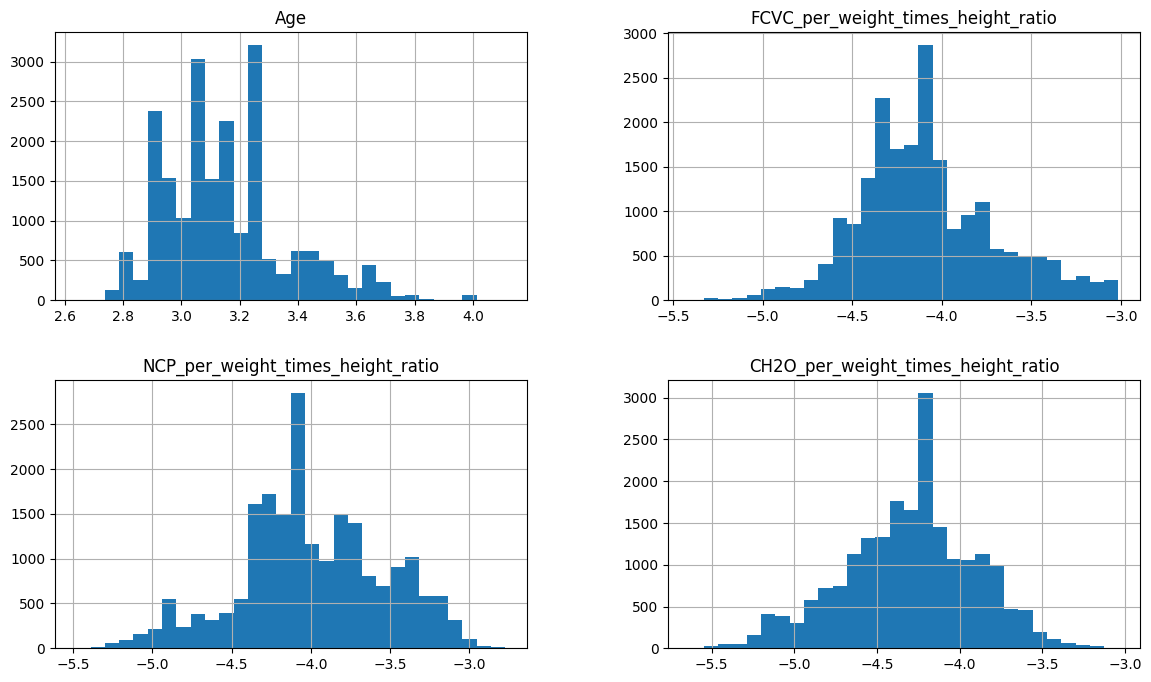

In [19]:
train_set_exp[log_cols].hist(bins=30, figsize=(14, 8))
plt.show()

In [20]:
corr_matrix = train_set_exp.corr()
display(corr_matrix["NObeyesdad_ordinal"].sort_values(ascending=False))

NObeyesdad_ordinal                    1.000000
Weight_per_height_ratio               0.954534
Weight                                0.921250
family_history_with_overweight        0.522026
Age                                   0.415503
CH2O                                  0.273154
FCVC                                  0.272933
FAVC                                  0.215401
CALC_ordinal                          0.189361
Height                                0.150141
NCP                                   0.027227
SMOKE                                 0.013501
MTRANS_ordinal                       -0.031141
Gender                               -0.067699
TUE                                  -0.121009
SCC                                  -0.184959
FAF                                  -0.234745
CAEC_ordinal                         -0.364052
CH2O_per_weight_times_height_ratio   -0.542796
NCP_per_weight_times_height_ratio    -0.600685
FCVC_per_weight_times_height_ratio   -0.626855
Name: NObeyes

In [21]:
std_scaler = StandardScaler()
train_set_exp_new_scaled = pd.DataFrame(std_scaler.fit_transform(train_set_exp), columns=train_set_exp.columns, index=train_set_exp.index)

display(train_set_exp_new_scaled)

,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CAEC_ordinal,CALC_ordinal,MTRANS_ordinal,...,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,Weight_per_height_ratio,Age,FCVC_per_weight_times_height_ratio,NCP_per_weight_times_height_ratio,CH2O_per_weight_times_height_ratio
0,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438,-0.337845,0.471288,0.356902,...,1.004152,0.469099,0.30588,-0.109287,-0.185009,-0.235997,0.230022,-0.393023,0.330837,0.967717
1,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,1.889204,-1.639846,-2.056312,...,-0.995866,0.469099,0.30588,-0.109287,-0.185009,-1.023129,-1.191855,0.767837,1.310671,1.274713
2,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,-0.337845,-1.639846,0.356902,...,-0.995866,0.469099,0.30588,-0.109287,-0.185009,-1.517658,-1.191855,0.698709,-0.250365,1.247610
3,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455,-0.337845,0.471288,0.356902,...,-0.995866,0.469099,0.30588,-0.109287,-0.185009,1.727599,-0.485976,-0.589554,-0.701463,-1.499763
4,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111,-0.337845,0.471288,0.356902,...,1.004152,0.469099,0.30588,-0.109287,-0.185009,-0.170281,1.429488,-0.300741,-1.127258,-0.516098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.760293,0.996987,0.888355,0.338364,0.201151,0.416056,-0.697686,-0.337845,0.471288,0.356902,...,1.004152,0.469099,0.30588,-0.109287,-0.185009,0.899564,0.360141,-0.380785,-0.468419,-0.599466
20754,0.111729,-1.436296,1.039171,1.756085,-1.691863,1.214691,0.636513,1.889204,0.471288,0.356902,...,1.004152,-2.131745,0.30588,-0.109287,-0.185009,-1.522579,-1.191855,1.926377,2.020643,-0.368125
20755,1.366537,0.670717,-0.071439,0.338364,-0.048349,0.210303,0.966092,-0.337845,-1.639846,0.356902,...,1.004152,0.469099,0.30588,-0.109287,-0.185009,0.447221,-0.678822,-0.755629,-0.362341,-0.660561
20756,-0.002805,-0.165574,0.422594,-1.119801,0.189694,-1.171141,0.593055,-0.337845,-1.639846,-2.056312,...,1.004152,0.469099,0.30588,-0.109287,-0.185009,-0.161526,1.743491,0.302572,-0.617488,0.274675


2. Pipeline

In [31]:
display(train_set)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [185]:
X_train = train_set.drop("NObeyesdad", axis=1)
y_train = train_set[["NObeyesdad"]].values
display(X_train)
display(y_train)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile


array([['Overweight_Level_II'],
       ['Normal_Weight'],
       ['Insufficient_Weight'],
       ...,
       ['Obesity_Type_II'],
       ['Overweight_Level_II'],
       ['Obesity_Type_II']], dtype=object)

In [186]:
cat_pipeline = make_pipeline(
    OrdinalEncoder(categories=[["Female", "Male"],
                               ["no", "yes"],
                               ["yes", "no"],
                               ["Always", "Frequently", "Sometimes", "no"],
                               ["no", "yes"],
                               ["yes", "no"],
                               ["no", "Sometimes", "Frequently"],
                               ["Walking", "Bike", "Public_Transportation", "Motorbike", "Automobile"]
                                ]),
    StandardScaler())

def column_ratio_1(X):
    return X[:, [0]] / X[:, [1]]

def column_ratio_2(X):
    return X[:, [0]] / (X[:, [1]] * X[:, [2]])

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline_1():
    return make_pipeline(
        FunctionTransformer(column_ratio_1, validate=True, feature_names_out=ratio_name),
        StandardScaler())

def ratio_pipeline_2():
    return make_pipeline(
        FunctionTransformer(column_ratio_2, validate=True, feature_names_out=ratio_name),
        FunctionTransformer(np.log, feature_names_out="one-to-one"),
        StandardScaler())

log_pipeline = make_pipeline(
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

std_pipeline = make_pipeline(
    StandardScaler())

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ("weight_per_height", ratio_pipeline_1(), ["Weight", "Height"]),
    ("FCVC_per_weight_times_height", ratio_pipeline_2(), ["FCVC", "Weight", "Height"]),
    ("NCP_per_weight_times_height", ratio_pipeline_2(), ["NCP", "Weight", "Height"]),
    ("CH2O_per_weight_times_height", ratio_pipeline_2(), ["CH2O", "Weight", "Height"]),
    ("log", log_pipeline, ["Age"]),
    ("std", std_pipeline, ["FAF", "TUE"])
    ],
    remainder="drop")

In [189]:
log_reg_clf = make_pipeline(preprocessing, LogisticRegression(max_iter=1000))
log_reg_clf.fit(X_train, y_train.ravel())

y_train_pred = log_reg_clf.predict(X_train)
print(f"Logistic regression classifier accuracy on train set: {round(accuracy_score(y_train_pred, y_train), 2)}")

Logistic regression classifier accuracy on train set: 0.86


In [191]:
tree_clf = make_pipeline(preprocessing, DecisionTreeClassifier(random_state=42))
tree_clf.fit(X_train, y_train.ravel())

y_train_pred = tree_clf.predict(X_train)
print(f"Decision tree classifier accuracy on train set: {round(accuracy_score(y_train_pred, y_train), 2)}")

Decision tree classifier accuracy on train set: 1.0


In [195]:
tree_clf_cv_acc = cross_val_score(tree_clf, X_train, y_train, cv=10)
pd.Series(tree_clf_cv_acc).describe()

count    10.000000
mean      0.833317
std       0.009156
min       0.816474
25%       0.827831
50%       0.834538
75%       0.838150
max       0.847303
dtype: float64

In [198]:
forest_clf = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))
forest_clf_cv_acc = cross_val_score(forest_clf, X_train, y_train.ravel(), cv=10)
pd.Series(forest_clf_cv_acc).describe()

count    10.000000
mean      0.893053
std       0.004943
min       0.887283
25%       0.889090
50%       0.893494
75%       0.894027
max       0.903179
dtype: float64